# Variational Autoencoder

1. Do a hyperparameter gridsearch over the following to find the best fitting VAE, i.e. the model that best fittes the data. 
    - {encoder : {nr. layers, dim. per layer, activation function}
    - hidenDimension : {dimension}
    - decoder: {nr. layers, dim. per layer, activation function}}


In [40]:
import random
def rand_dec_layers(size, rang):
    s,e = rang
    sampled_list = random.sample(range(s,e),size)
    sampled_list.sort()
    return sampled_list
        
hyperparameters_encoder = {"nr_hidden_layers": list(range(2,12)),
                           "dim_per_layer" : lambda x : rand_dec_layers(x,(2,12)), 
                           "activation_function": ["relu","sigma", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
                          "reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## VAE

### A sampling layer

In [42]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [43]:
def create_encoder(latent_dim, input_shape):
    # An encoder of single selfs.
    encoder_inputs = keras.Input(shape=(input_shape,))
    x = layers.Dense(10, activation="relu")(encoder_inputs)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(6, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

## Decoder

In [44]:
def create_decoder(latent_dim):
    decoder_inputs = keras.Input(shape=(latent_dim,), name ="latent_variable")
    x = layers.Dense(6,activation="relu")(decoder_inputs)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(10, activation="relu")(x)
    decoder_outputs = layers.Dense(12, activation="relu", name="output_layer")(x)
    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    return decoder

## VAE-model

In [68]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            
            # Use MSE as a construction loss
            mse = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = mse(data, reconstruction)
            
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## DATA

In [46]:
import math

In [4]:
cells = pd.read_csv("ModifiedDATA/scaled_ra.csv")

In [47]:
control_group = cells[cells.group == 'control']
diseased_group = cells[cells.group == 'diseased']

### Diseased Group VAE

In [79]:
diseased_data = diseased_group[diseased_group.columns.difference(["group", "id"])]

latent_dim = 2
input_shape = diseased_data.columns.shape[0]
diseased_encoder = create_encoder(latent_dim, input_shape)
diseased_decoder = create_decoder(latent_dim)

diseased_vae = VAE(diseased_encoder, diseased_decoder)
diseased_vae.compile(optimizer=keras.optimizers.Adam())
diseased_vae.fit(diseased_data, epochs=20, batch_size=128)

Epoch 1/20
3125/3125 [==============================] - 3s 1ms/step - loss: 2.0662 - reconstruction_loss: 1.8657 - kl_loss: 0.2005
Epoch 2/20
3125/3125 [==============================] - 3s 845us/step - loss: 1.8299 - reconstruction_loss: 1.4907 - kl_loss: 0.3392
Epoch 3/20
3125/3125 [==============================] - 3s 837us/step - loss: 1.7554 - reconstruction_loss: 1.2677 - kl_loss: 0.4877
Epoch 4/20
3125/3125 [==============================] - 2s 788us/step - loss: 1.7459 - reconstruction_loss: 1.2314 - kl_loss: 0.5145
Epoch 5/20
3125/3125 [==============================] - 3s 894us/step - loss: 1.7378 - reconstruction_loss: 1.2111 - kl_loss: 0.5267
Epoch 6/20
3125/3125 [==============================] - 3s 845us/step - loss: 1.7338 - reconstruction_loss: 1.1960 - kl_loss: 0.5379
Epoch 7/20
3125/3125 [==============================] - 3s 812us/step - loss: 1.7294 - reconstruction_loss: 1.1862 - kl_loss: 0.5432
Epoch 8/20
3125/3125 [==============================] - 3s 897us/step -

### Control group vae

In [70]:
control_data = control_group[control_group.columns.difference(["group", "id"])]

latent_dim = 2
input_shape = control_data.columns.shape[0]
control_encoder = create_encoder(latent_dim, input_shape)
control_decoder = create_decoder(latent_dim)

control_vae = VAE(control_encoder, control_decoder)
control_vae.compile(optimizer=keras.optimizers.Adam())
control_vae.fit(control_data, epochs=20, batch_size=128)

Epoch 1/20
3125/3125 [==============================] - 4s 1ms/step - loss: 1.5981 - reconstruction_loss: 1.4449 - kl_loss: 0.1531
Epoch 2/20
3125/3125 [==============================] - 3s 895us/step - loss: 1.3221 - reconstruction_loss: 0.8579 - kl_loss: 0.4641
Epoch 3/20
3125/3125 [==============================] - 3s 836us/step - loss: 1.2701 - reconstruction_loss: 0.7403 - kl_loss: 0.5299
Epoch 4/20
3125/3125 [==============================] - 3s 981us/step - loss: 1.2649 - reconstruction_loss: 0.7291 - kl_loss: 0.5358
Epoch 5/20
3125/3125 [==============================] - 2s 778us/step - loss: 1.2615 - reconstruction_loss: 0.7162 - kl_loss: 0.5453
Epoch 6/20
3125/3125 [==============================] - 2s 776us/step - loss: 1.2598 - reconstruction_loss: 0.7049 - kl_loss: 0.5549
Epoch 7/20
3125/3125 [==============================] - 2s 790us/step - loss: 1.2540 - reconstruction_loss: 0.6879 - kl_loss: 0.5661
Epoch 8/20
3125/3125 [==============================] - 3s 921us/step -

In [71]:
def plot_label_clusters(encoder, decoder, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    z_mean, z_var, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Mean")
    plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
    #plt.colorbar()
    plt.legend()
    plt.xlabel("z_0")
    plt.ylabel("z_1")
    plt.show()

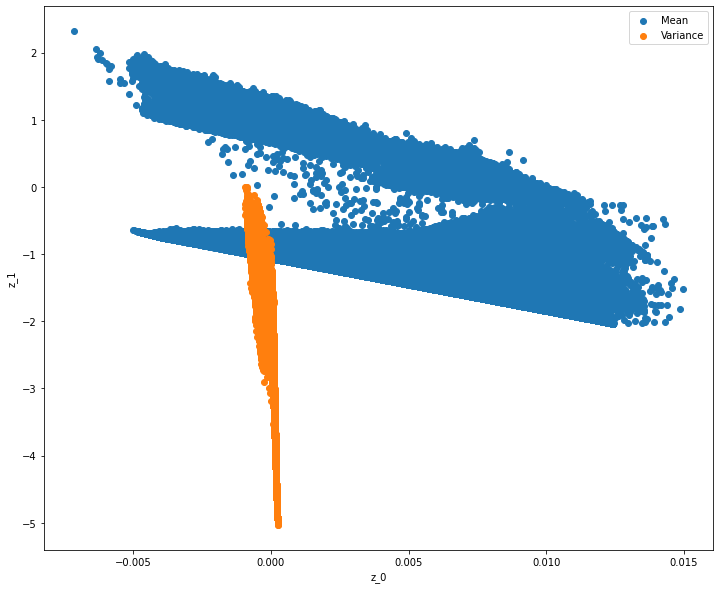

In [72]:
plot_label_clusters(control_encoder, control_decoder, control_data)

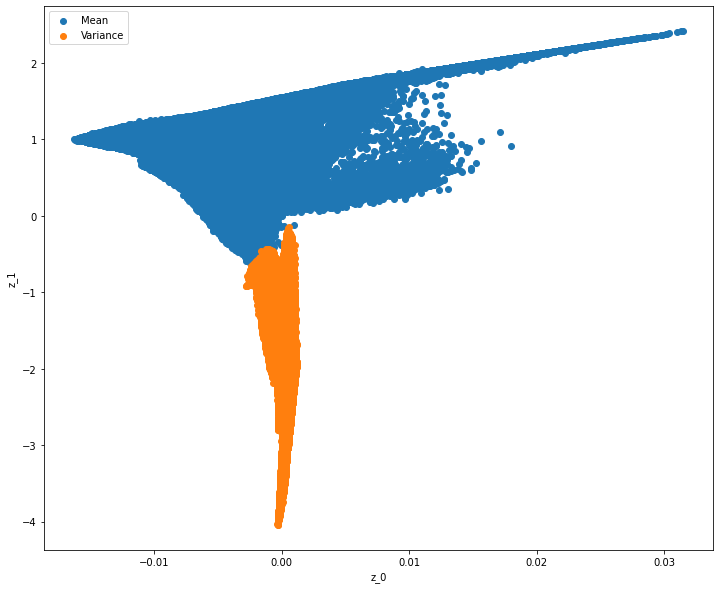

In [73]:
plot_label_clusters(diseased_encoder, diseased_decoder, diseased_data)

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)